### Import statements

In [1]:
from dicesapi import DicesAPI, SpeechGroup
from dicesapi.jupyter import NotebookPBar
from dicesapi.text import CtsAPI
from cltk.morphology.universal_dependencies_features import Person, Mood, Number, VerbForm, PrononimalType, Possessive
import pandas as pd
from matplotlib import pyplot as plt
import os
import re
import json
import numpy as np
from sklearn.decomposition import PCA
import dicesapi.text

### Connection to DICES

In [2]:
api = DicesAPI(
    dices_api = 'http://localhost:8000/api', 
    logfile = 'nonnus.log', 
    progress_class = NotebookPBar,
)
cts = CtsAPI(
    dices_api = api,
    servers = {None:'http://localhost:5000/cts'},
)

### Read the list of mother-child pairs

In [3]:
mothers_file = os.path.join('data', 'mother-child.csv')
mothers = pd.read_csv(mothers_file, sep='\t')
mothers

,spkr,addr
0,Alcimede,Jason
1,Aphrodite,Eros
2,Chalciope,Argus (son of Phrixus)
3,Chalciope,sons of Phrixus
4,Chariclo,Tiresias
...,...,...
56,Venus-huntress,Aeneas
57,Venus,Amor
58,Venus,Aeneas
59,Cybele,Jupiter


### Download mother speeches

In [4]:
# get speeches
mother_speeches = [
    api.getSpeeches(spkr_inst_name=rec['spkr'], addr_inst_name=rec['addr']) 
    for rec in mothers.to_dict(orient='records')]

# add them to the table
mothers = mothers.assign(
    speeches = mother_speeches,
    n = [len(speech_group) for speech_group in mother_speeches]
)
    
# turn the downloaded speeches into a SpeechGroup
empty = SpeechGroup([], api=api)
mother_speeches = sum(mothers.speeches, start=empty)

### Download the entire corpus to use as a benchmark

Note that because of the way DicesAPI caches speech objects, the ones we've already downloaded are reused here and not duplicated or re-downloaded. If the API sees that we've requested the same speech, we just get a pointer to the earlier one.

In [5]:
all_speeches = api.getSpeeches(progress=True)

#### ⚠️ Workaround for certain Claudian texts

These texts have an extra hierarchical level inserted into their loci on Perseus' CTS server. This is a temporary workaround to convert our loci to a form that the server understands.

Because `all_speeches` and `mother_speeches` just contain pointers to the same object pool, we can do this modification once on `all_speeches` and the mother speeches will also be affected.

In [6]:
adj_book_line = [
    'De Raptu Proserpinae',
    'In Rufinum',
]
adj_line = [
    'Panegyricus de consulatu Manlii Theodori',
    'Panegyricus de Tertio Consulatu Honorii Augusti',
    'Panegyricus de Sexto Consulatu Honorii Augusti',
    'Epithalamium de Nuptiis Honorii Augusti',
    'De Bello Gothico',
    'Psychomachia',    
]

for s in all_speeches:
    if s.work.title in adj_book_line:
        m = re.fullmatch(r'(\d+)\.(\d+)', s.l_fi)
        if m:
            s.l_fi = f'{m.group(1)}.1.{m.group(2)}'

        m = re.fullmatch(r'(\d+)\.(\d+)', s.l_la)
        if m:
            s.l_la = f'{m.group(1)}.1.{m.group(2)}'

    elif s.work.title in adj_line:
        m = re.fullmatch(r'(\d+)', s.l_fi)
        if m:
            s.l_fi = '1.' + m.group(1)

        m = re.fullmatch(r'(\d+)', s.l_la)
        if m:
            s.l_la = '1.' + m.group(1)

### Get the text

In [7]:
pbar = NotebookPBar(max=len(all_speeches))

for i, s in enumerate(all_speeches):
    if (i % 100 == 0) or (i == len(all_speeches) - 1):
        pbar.update(i)
    if not hasattr(s, 'passage') or s.passage is None:
        s.passage = cts.getPassage(s)
    if s.passage is None:
        print(f'Failed: {s.work.urn}\t{s.work.title}\t{s.l_range}')

Failed: 	Orphic Argonautica	77-96
Failed: 	Orphic Argonautica	98-113
Failed: 	Orphic Argonautica	256-267
Failed: 	Orphic Argonautica	283-294
Failed: 	Orphic Argonautica	335-354
Failed: 	Orphic Argonautica	544-557
Failed: 	Orphic Argonautica	823-828
Failed: 	Orphic Argonautica	832-842
Failed: 	Orphic Argonautica	847-856
Failed: 	Orphic Argonautica	1153-1159
Failed: 	Orphic Argonautica	1164-1174
Failed: 	Orphic Argonautica	1231-1243
Failed: 	Orphic Argonautica	1329-1336
Failed: urn:cts:greekLit:tlg0001.tlg001.perseus-grc2	Argonautica	3.727-3.739
Failed: urn:cts:latinLit:stoa0089.stoa005.perseus-lat2	De Raptu Proserpinae	2.praef.33-2.praef.48
Failed: 	Homerocentones	42-66
Failed: 	Homerocentones	100-176
Failed: 	Homerocentones	178-203
Failed: 	Homerocentones	230-245
Failed: 	Homerocentones	253-263
Failed: 	Homerocentones	265-272
Failed: 	Homerocentones	385-432
Failed: 	Homerocentones	438-441
Failed: 	Homerocentones	444-446
Failed: 	Homerocentones	474-518
Failed: 	Homerocentones	598-605
Fa

Failed: urn:cts:latinLit:phi0959.phi006.perseus-lat2	Metamorphoses	1.545-1.546
Failed: urn:cts:latinLit:phi0959.phi006.perseus-lat2	Metamorphoses	4.793-4.803
Failed: urn:cts:latinLit:phi0959.phi006.perseus-lat2	Metamorphoses	14.383-14.385
Failed: 	D. Sanctae Sophiae	91-98
Failed: 	D. Sanctae Sophiae	220-242
Failed: 	D. Sanctae Sophiae	248-254
Failed: 	Batrachomyomachia	13-21
Failed: 	Batrachomyomachia	25-55
Failed: 	Batrachomyomachia	57-64
Failed: 	Batrachomyomachia	93-97
Failed: 	Batrachomyomachia	110-120
Failed: 	Batrachomyomachia	139-143
Failed: 	Batrachomyomachia	147-159
Failed: 	Batrachomyomachia	174-176
Failed: 	Batrachomyomachia	178-196
Failed: 	Batrachomyomachia	272-276
Failed: 	Batrachomyomachia	278-283
Failed: 	Megara	1-55
Failed: 	Megara	62-125
Failed: urn:cts:latinLit:phi1020.phi001.perseus-lat2	Thebaid	4.832-4.850
Failed: 	Sack of Troy	120-151
Failed: 	Sack of Troy	265-282
Failed: 	Sack of Troy	284-290
Failed: 	Sack of Troy	292-303
Failed: 	Sack of Troy	376-416
Failed: 	Sa

### Add supplementary text for speeches not in Perseus

In [8]:
with open('data/supp_mother_speeches.txt') as f:
    supplement = json.load(f)
    
for rec in supplement:
    for s in all_speeches:
        if s.id == rec['id']:
            print(s)
            s.passage = dicesapi.text.Passage()
            s.passage.line_array = rec['line_array']
            s.passage.text = ' '.join([l['text'] for l in s.passage.line_array])
            s.passage.speech = s
            break

<Speech 4483: Homerocentones 598-605>
<Speech 4548: Homerocentones 2059-2064>
<Speech 4549: Homerocentones 2068-2076>
<Speech 4553: Homerocentones 2187-2188>
<Speech 4416: St. Cyprian 1.1.51-1.1.52>
<Speech 3696: Paraphrase 2.19-2.20>


### Remove some problem speeches

#### No text

In [9]:
test_speeches = all_speeches.advancedFilter(lambda s: s.passage is not None).sorted()

#### Very long speeches

In [10]:
for s in test_speeches:
    if len(s.passage.line_array) > 600:
        print(s)
test_speeches = test_speeches.advancedFilter(lambda s: len(s.passage.line_array)<600).sorted()

<Speech 890: Odyssey 9.2-11.332>
<Speech 957: Odyssey 11.378-12.453>
<Speech 1552: Aeneid 2.3-3.715>


### Class as mother/non-mother

In [11]:
for s in all_speeches:
    if s in mother_speeches:
        s.is_mother = True
    else:
        s.is_mother = False

In [12]:
kept_mother = len([s for s in test_speeches if s.is_mother])
kept_non_mother = len([s for s in test_speeches if not s.is_mother])


print(f'{kept_mother}/{len(mother_speeches)} mother speeches selected')
print(f'{kept_non_mother}/{len(all_speeches) - len(mother_speeches)} non-mother speeches selected')

95/95 mother speeches selected
4014/4597 non-mother speeches selected


### Run NLP

In [13]:
pbar = NotebookPBar(max=len(test_speeches))

for i, s in enumerate(test_speeches):
    if i % 10 == 0 or i == len(test_speeches) - 1:
        pbar.update(i+1)
    if s.passage is not None:
        if s.passage.cltk_doc is None:
            s.passage.runCltkPipeline(index=False)
    if s.passage.cltk_doc is None:
        print(f'CLTK Failed: {s.work.urn}\t{s.work.title}\t{s.l_range}')

## Basic stats

In [14]:
def extractCltkFeature(token, feature):
    if feature in token.features.features:
        return ','.join(str(feat) for feat in token.features[feature])
    else:
        return ''

In [15]:
pbar = NotebookPBar(max=len(test_speeches))
rows = []

for i, s in enumerate(test_speeches):
    if i % 10 == 0 or i == len(test_speeches) - 1:
        pbar.update(i+1)
    for w in s.passage.cltk_doc:
        rows.append(dict(
            speech_id = s.id,
            lang = s.work.lang,    
            auth = s.author.name,
            work = s.work.title,
            loci = s.l_range,
            spkr = ','.join([inst.name for inst in s.spkr]),
            addr = ','.join([inst.name for inst in s.addr]),
            tags = ','.join([tag['type'] for tag in s._attributes.get('tags', [])]),
            type = s.type,
            mother = s.is_mother,
            token = w.string,
            nlines = len(s.passage.line_array),
            lemma = w.lemma,
            pos = w.upos,
            pers = (extractCltkFeature(w, Person) + extractCltkFeature(w, Number)) if extractCltkFeature(w, VerbForm) == 'finite' else '',
            verb = extractCltkFeature(w, VerbForm),
            pron = extractCltkFeature(w, PrononimalType),
            poss = extractCltkFeature(w, Possessive),
            mood = extractCltkFeature(w, Mood) if extractCltkFeature(w, VerbForm) == 'finite' else extractCltkFeature(w, VerbForm),
            feat = str(w.features),
        ))

cltk_token_table = pd.DataFrame(rows)

# drop tokens with no alpha chars
cltk_token_table = cltk_token_table.loc[cltk_token_table.token.str.contains(r'[a-zα-ω]')]
cltk_token_table

,speech_id,lang,auth,work,loci,spkr,addr,tags,type,mother,token,nlines,lemma,pos,pers,verb,pron,poss,mood,feat
0,1385,greek,Apollonius,Argonautica,1.242-1.246,citizens,citizens,del,S,False,Ζεῦ,5,Ζεύς,PROPN,,,,,,"{Case: [vocative], Gender: [masculine], Number..."
1,1385,greek,Apollonius,Argonautica,1.242-1.246,citizens,citizens,del,S,False,ἄνα,5,ἀνος,NOUN,,,,,,"{Case: [vocative], Gender: [masculine], Number..."
2,1385,greek,Apollonius,Argonautica,1.242-1.246,citizens,citizens,del,S,False,τίς,5,τίς,PRON,,,interrogative,,,"{Case: [nominative], Gender: [masculine], Numb..."
3,1385,greek,Apollonius,Argonautica,1.242-1.246,citizens,citizens,del,S,False,Πελίαο,5,Πέλια,PROPN,,,,,,"{Case: [genitive], Gender: [masculine], Number..."
4,1385,greek,Apollonius,Argonautica,1.242-1.246,citizens,citizens,del,S,False,νόος,5,νόος,NOUN,,,,,,"{Case: [nominative], Gender: [masculine], Numb..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373495,1868,latin,Virgil,Aeneid,12.947-12.949,Aeneas,Turnus,"thr,tau",D,False,poenam,3,poena,NOUN,,,,,,"{Case: [accusative], Gender: [feminine], Numbe..."
373496,1868,latin,Virgil,Aeneid,12.947-12.949,Aeneas,Turnus,"thr,tau",D,False,scelerato,3,scelero,VERB,,participle,,,participle,"{Aspect: [perfective], Case: [ablative], Degre..."
373497,1868,latin,Virgil,Aeneid,12.947-12.949,Aeneas,Turnus,"thr,tau",D,False,ex,3,ex,ADP,,,,,,{AdpositionalType: [preposition]}
373498,1868,latin,Virgil,Aeneid,12.947-12.949,Aeneas,Turnus,"thr,tau",D,False,sanguine,3,sanguis,NOUN,,,,,,"{Case: [ablative], Gender: [masculine], Number..."


In [16]:
labels = cltk_token_table.groupby('speech_id').agg(
    lang = ('lang', 'first'),
    auth = ('auth', 'first'),
    work = ('work', 'first'),
    loci = ('loci', 'first'),
    spkr = ('spkr', 'first'),
    addr = ('addr', 'first'),
    nlines = ('nlines', 'first'),
    mother = ('mother', 'first'),
    ntokens = ('token', 'count'),
)

In [17]:
labels.groupby(['lang', 'mother', 'auth']).agg(
    speeches = ('loci', 'count'),
    lines = ('nlines', 'sum'),
)

speeches  lines
lang  mother auth                             
greek False  Apollonius             138   1662
             Callimachus             30    214
             Colluthus               14    130
             Hesiod                  12     44
             Homer                 1345  14024
             Homeric Hymns           58    763
             Moschus                  4     39
             Nonnus                 346   7656
             Oppian                  13     51
             Quintus                170   1990
             Theocritus              16    226
      True   Apollonius               4     41
             Callimachus              3     32
             Colluthus                2     30
             Eudocia                  5     28
             Hesiod                   1      3
             Homer                   23    206
             Homeric Hymns            4     32
             Nonnus                   7    243
             Oppian                   3     21
             Quintus                  5     89
             Theocritus               1      3
latin False  Claudian               106   2606
             Lucan                  122   2573
             Ovid                   497   7666
             Prudentius              13    330
             Silius                 312   3832
             Statius                293   3941
             Valerius Flaccus       192   1954
             Virgil                 332   3690
      True   Claudian                 5     51
             Lucan                    1     54
             Ovid                     6     75
             Silius                   6     68
             Statius                 10    202
             Valerius Flaccus         1     15
             Virgil                   8    137

In [18]:
cltk_token_table.groupby(['mother', 'lang']).agg(
    speeches = ('speech_id', 'nunique'),
    tokens = ('token', 'count'),
)

speeches  tokens
mother lang                   
False  greek      2146  181665
       latin      1867  175275
True   greek        58    4937
       latin        37    4039

In [19]:
pd.DataFrame(dict(
    lang = s.lang,
    mother = s.is_mother,
    lines = len(s.passage.line_array),
) for s in test_speeches).groupby(['mother', 'lang']).agg(
    speeches = ('lines', 'count'),
    lines = ('lines', 'sum'))

speeches  lines
mother lang                  
False  greek      2146  26799
       latin      1868  26594
True   greek        58    728
       latin        37    602

In [20]:
mask = cltk_token_table.verb == 'finite'
groups = cltk_token_table[mask].groupby(['lang'])

for name, group in groups:
    display(pd.crosstab(group.mother, group.mood, normalize='index'))

mood,,imperative,indicative,optative,subjunctive
mother,,,,,
False,0.004044,0.146814,0.725418,0.043118,0.080606
True,0.002813,0.160338,0.735584,0.023910,0.077356


mood,,imperative,indicative,subjunctive
mother,,,,
False,0.001873,0.123578,0.749722,0.124827
True,0.005997,0.163418,0.739130,0.091454


In [21]:
mask = cltk_token_table.verb == 'finite'
groups = cltk_token_table[mask].groupby(['lang'])

for name, group in groups:
    display(pd.crosstab(group.mother, group.pers, normalize='index'))

pers,firstplural,firstsingular,plural,secondplural,secondsingular,singular,thirdplural,thirdsingular
mother,,,,,,,,
False,0.052642,0.164689,0.001096,0.035749,0.229197,0.003023,0.112010,0.401595
True,0.029536,0.171589,0.001406,0.026723,0.279887,0.005626,0.085795,0.399437


pers,,first,firstplural,firstsingular,plural,second,secondplural,secondsingular,singular,thirdplural,thirdsingular
mother,,,,,,,,,,,
False,0.000069,0.000035,0.034971,0.073307,0.001006,0.000035,0.059187,0.207501,0.001180,0.110810,0.511900
True,0.000000,0.000000,0.028486,0.110945,0.005997,0.000000,0.056972,0.307346,0.001499,0.065967,0.422789


In [22]:
mask = cltk_token_table.pron != ''
groups = cltk_token_table[mask].groupby(['lang'])

for name, group in groups:
    display(name, pd.crosstab(group.mother, group.pron, normalize='index'))

('greek',)

pron,demonstrative,interrogative,personal,reciprocal,relative
mother,,,,,
False,0.081885,0.075104,0.615264,0.003361,0.224386
True,0.083160,0.093555,0.656965,0.006237,0.160083


('latin',)

pron,article,demonstrative,emphatic,indefinite,interrogative,negative,personal,relative
mother,,,,,,,,
False,0.000046,0.221855,0.007157,0.200936,0.002110,0.011240,0.388981,0.167676
True,0.000000,0.227929,0.008026,0.168539,0.001605,0.011236,0.426966,0.155698


#### Possessives

What tokens are being counted by CLTK?

In [23]:
(cltk_token_table.loc[cltk_token_table.poss != '']
 .groupby('token')
 .agg(count=('token', 'count'))
 .sort_values('count', ascending=False)
).iloc[:50]

,count
token,
mea,283
tua,264
ἐμὸν,212
nostra,173
sua,126
nostris,120
nostro,118
nostri,99
ἐμὸς,90


I'm going to remove a couple of the most frequent misclassifications: 

 | tok | count |
 |---|---|
 | μάλʼ	| 62 |
 | τόδʼ	| 40 |
 | ἄπο	| 17 |

In [24]:
mask = cltk_token_table.token.isin(['μάλʼ', 'τόδʼ','ἄπο']) & cltk_token_table.poss
cltk_token_table.loc[mask, 'poss'] = ''

In [25]:
groups = cltk_token_table.groupby(['lang'])

for name, group in groups:
    display(name, pd.crosstab(group.mother, group.poss, normalize='index'))

('greek',)

poss,,pos
mother,,
False,0.989882,0.010118
True,0.985821,0.014179


('latin',)

poss,,pos
mother,,
False,0.982348,0.017652
True,0.978955,0.021045


### Personal Pronouns

Again, let's see what gets included.

In [26]:
(cltk_token_table.loc[cltk_token_table.pron == 'personal']
 .groupby('token')
 .agg(count=('token', 'count'))
 .sort_values('count', ascending=False)
)

,count
token,
μοι,1050
mihi,950
τοι,919
te,787
tibi,752
...,...
succede,1
subistis,1
suasi,1


Remove the most frequent misclassifications

In [27]:
to_remove = ['αὐτὰρ', 'θʼ', 'κʼ', 'ὅττι', 'ἦμαρ', 'μάλʼ', 'αὖτε', 'ἐσσι', 'νυ', 'πώ', 'ἐνθάδʼ', 'ῥα', 'οὕνεκʼ', 'ἦε', 'ἔτʼ', 'ἠμὲν', 'κῆρ', 'δεῦρʼ', 'νύ', 'ὧδʼ', 'χʼ', 'ὀΐω', 'ἦτορ', 'αὐτίκʼ', 'vivo', 'εἵνεκʼ', 'ἄρʼ', 'ποθʼ', 'misero', 'αἲ', 'δῶ', 'μὰ', 'ποθι', 'πάντεσσι', 'κεῖσʼ', 'virum', 'ἄρ', 'ᾗσι', 'ἠδὲ', 'utinam', 'παρὲξ', 'ὧς', 'τοῖα', 'feram', 'tantis', 'totis', 'οὐκί', 'ἄντην', 'uestris', 'Ζεῦ', 'θην', 'μέγʼ', 'οὕνεκα', 'αὐτάρ', 'Ἐνυώ', 'ἀμφοτέρω', 'ἀτάρ', 'novis', 'πέρ', 'ὀίω', 'κεῖθι', 'θεά', 'εὑ', 'αἰνὰ', 'querellis', 'deosque', 'οἴω', 'dis', 'superisque', 'ἐσσὶ', 'ἂψ', 'τῆλε', 'satam', 'ultro', 'verso', 'verum', 'Pisa', 'ὄφρʼ', 'magne', 'tutos', 'aequis', 'illic', 'agedum', 'Achaide', 'ἄναξ', 'ambobus', 'opibusque', 'saeve', 'votisque', 'πρόες',]
mask = cltk_token_table.token.isin(to_remove) & (cltk_token_table.pron == 'personal')
cltk_token_table.loc[mask, 'pron'] = ''

In [28]:
groups = cltk_token_table.groupby(['lang'])

for name, group in groups:
    display(name, pd.crosstab(group.mother, group.pron, normalize='index'))

('greek',)

pron,,demonstrative,interrogative,personal,reciprocal,relative
mother,,,,,,
False,0.911585,0.007778,0.007134,0.05187,0.000319,0.021314
True,0.908649,0.008102,0.009115,0.05793,0.000608,0.015597


('latin',)

pron,,article,demonstrative,emphatic,indefinite,interrogative,negative,personal,relative
mother,,,,,,,,,
False,0.876389,0.000006,0.027591,0.000890,0.024989,0.000262,0.001398,0.047622,0.020853
True,0.846001,0.000000,0.035157,0.001238,0.025997,0.000248,0.001733,0.065610,0.024016


## Load hand-selected feature sets

In [29]:
excel_file = '/Users/chris/Dropbox/Epic Speeches/Listen to mummy/classification.xlsx'
lemma_class = pd.read_excel(excel_file, 'maternal diction')

In [30]:
lem_dict = dict()

for label in lemma_class.label.unique():
    if not pd.isna(label):
        lem_dict[label] = lemma_class.loc[lemma_class.label == label, 'lemma'].values

In [31]:
lem_dict['giving']

array(['dono', 'donum', 'gratia', 'gratus', 'munus', 'pignum', 'pignus',
       'γέρας', 'δίδωμι', 'δώρημα', 'δῶρον', 'μισθός', 'παρέχω', 'Χάρις',
       'χάρις', 'χαρίζομαι', 'χαρίζω', 'χρέος', 'ἁνδάνω', 'ἐγγυαλίζω'],
      dtype=object)

In [32]:
cltk_token_table['theme'] = ''

for label in ['family', 'giving', 'memory']:
    mask = cltk_token_table.lemma.isin(lem_dict[label])
    cltk_token_table.loc[mask, 'theme'] = label

In [33]:
groups = cltk_token_table.groupby(['lang'])

for name, group in groups:
    display(name, pd.crosstab(group.mother, group.theme, normalize='index'))

('greek',)

theme,,family,giving,memory
mother,,,,
False,0.973424,0.019905,0.005257,0.001415
True,0.948349,0.041321,0.007292,0.003038


('latin',)

theme,,family,giving,memory
mother,,,,
False,0.980476,0.015792,0.002276,0.001455
True,0.956672,0.036890,0.004704,0.001733


## Full feature set

In [34]:
feature_table = (
    cltk_token_table.pivot_table(
        index = 'speech_id',
        columns = 'theme',
        values = 'token',
        aggfunc = 'count',
        fill_value = 0,
    )
    .drop('', axis=1)
.join(
    cltk_token_table.pivot_table(
        index = 'speech_id',
        columns = 'mood',
        values = 'token',
        aggfunc = 'count',
        fill_value = 0,
    )
    .assign(
        subopt = lambda x: x['subjunctive'] + x['optative'])
    
    .drop(['', 'subjunctive', 'optative', 'gerund', 'gerundive'], axis=1)
)
.join(
    cltk_token_table.pivot_table(
        index = 'speech_id',
        columns = 'pers',
        values = 'token',
        aggfunc = 'count',
        fill_value = 0,
    )
    .drop(['', 'first', 'plural', 'second', 'singular'], axis=1)
)
.join(
    cltk_token_table.pivot_table(
        index = 'speech_id',
        columns = 'pron',
        values = 'token',
        aggfunc = 'count',
        fill_value = 0,
    ).loc[:,['interrogative', 'personal', 'reciprocal', 'relative']]
)
.join( 
    cltk_token_table.groupby('speech_id')['poss']
    .value_counts()
    .unstack()
    .fillna(0)
    .rename(columns={'pos':'possessive'})['possessive']
)
.div(labels.ntokens, axis=0)
)

feature_table

,family,giving,memory,imperative,indicative,infinitive,participle,subopt,firstplural,firstsingular,secondplural,secondsingular,thirdplural,thirdsingular,interrogative,personal,reciprocal,relative,possessive
speech_id,,,,,,,,,,,,,,,,,,,
1,0.088235,0.029412,0.000000,0.058824,0.029412,0.058824,0.058824,0.000000,0.000000,0.029412,0.058824,0.000000,0.029412,0.000000,0.000000,0.058824,0.0,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.037037,0.092593,0.000000,0.074074,0.018519,0.000000,0.037037,0.000000,0.055556,0.018519,0.037037,0.000000,0.111111,0.0,0.018519,0.037037
3,0.000000,0.000000,0.000000,0.023256,0.162791,0.000000,0.000000,0.023256,0.000000,0.069767,0.000000,0.093023,0.023256,0.023256,0.000000,0.093023,0.0,0.023256,0.046512
4,0.000000,0.000000,0.000000,0.015152,0.106061,0.015152,0.030303,0.030303,0.030303,0.015152,0.000000,0.015152,0.000000,0.090909,0.000000,0.030303,0.0,0.030303,0.000000
5,0.013699,0.000000,0.000000,0.027397,0.109589,0.041096,0.013699,0.027397,0.013699,0.027397,0.000000,0.041096,0.013699,0.068493,0.013699,0.109589,0.0,0.013699,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,0.000000,0.000000,0.006667,0.033333,0.073333,0.040000,0.060000,0.073333,0.000000,0.006667,0.026667,0.026667,0.020000,0.100000,0.000000,0.033333,0.0,0.026667,0.006667
4689,0.000000,0.000000,0.000000,0.000000,0.166667,0.023810,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.023810,0.0,0.047619,0.023810
4690,0.000000,0.000000,0.000000,0.000000,0.162791,0.023256,0.046512,0.000000,0.000000,0.023256,0.000000,0.023256,0.000000,0.116279,0.000000,0.046512,0.0,0.000000,0.000000


### Log frequencies

In [35]:
x = feature_table.apply(np.log)
x[feature_table==0] = np.nan
x

,family,giving,memory,imperative,indicative,infinitive,participle,subopt,firstplural,firstsingular,secondplural,secondsingular,thirdplural,thirdsingular,interrogative,personal,reciprocal,relative,possessive
speech_id,,,,,,,,,,,,,,,,,,,
1,-2.427748,-3.526361,NaN,-2.833213,-3.526361,-2.833213,-2.833213,NaN,NaN,-3.526361,-2.833213,NaN,-3.526361,NaN,NaN,-2.833213,NaN,NaN,NaN
2,NaN,NaN,NaN,-3.295837,-2.379546,NaN,-2.602690,-3.988984,NaN,-3.295837,NaN,-2.890372,-3.988984,-3.295837,NaN,-2.197225,NaN,-3.988984,-3.295837
3,NaN,NaN,NaN,-3.761200,-1.815290,NaN,NaN,-3.761200,NaN,-2.662588,NaN,-2.374906,-3.761200,-3.761200,NaN,-2.374906,NaN,-3.761200,-3.068053
4,NaN,NaN,NaN,-4.189655,-2.243745,-4.189655,-3.496508,-3.496508,-3.496508,-4.189655,NaN,-4.189655,NaN,-2.397895,NaN,-3.496508,NaN,-3.496508,NaN
5,-4.290459,NaN,NaN,-3.597312,-2.211018,-3.191847,-4.290459,-3.597312,-4.290459,-3.597312,NaN,-3.191847,-4.290459,-2.681022,-4.290459,-2.211018,NaN,-4.290459,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,NaN,NaN,-5.010635,-3.401197,-2.612740,-3.218876,-2.813411,-2.612740,NaN,-5.010635,-3.624341,-3.624341,-3.912023,-2.302585,NaN,-3.401197,NaN,-3.624341,-5.010635
4689,NaN,NaN,NaN,NaN,-1.791759,-3.737670,-2.639057,NaN,NaN,NaN,NaN,NaN,NaN,-1.791759,NaN,-3.737670,NaN,-3.044522,-3.737670
4690,NaN,NaN,NaN,NaN,-1.815290,-3.761200,-3.068053,NaN,NaN,-3.761200,NaN,-3.761200,NaN,-2.151762,NaN,-3.068053,NaN,NaN,NaN


### Principal Components

In [36]:
pca_model = PCA(n_components=3)

pca = pd.DataFrame(
    index = feature_table.index,
    data = pca_model.fit_transform(feature_table), 
    columns=['PC1', 'PC2', 'PC3'])

## Plots

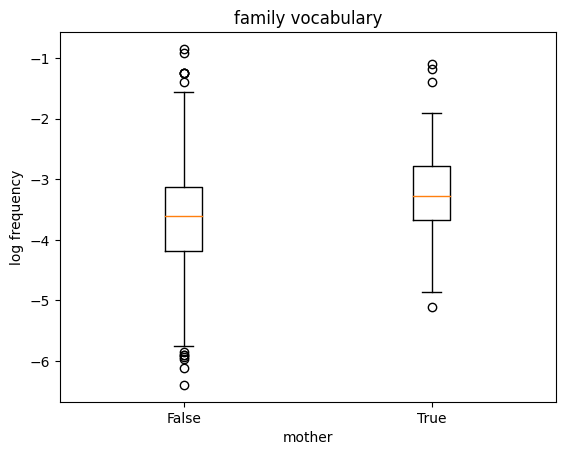

In [37]:
feat = 'family'
label = 'mother'

groups = x.groupby(labels[label])

fig, ax = plt.subplots()
ax.boxplot(
    [group[feat].dropna() for name, group in groups])
ax.set_xticks([j + 1 for j in range(len(groups))],
    labels = [name for name, group in groups])
ax.set_xlabel(label)
ax.set_ylabel('log frequency')
ax.set_title(f'{feat} vocabulary')
plt.savefig(f'{feat}_box.png')
plt.show()

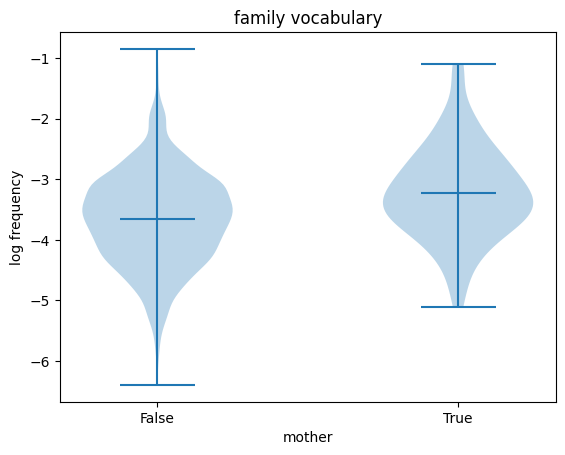

In [38]:
feat = 'family'
label = 'mother'

groups = x.groupby(labels[label])

fig, ax = plt.subplots()
ax.violinplot(
    [group[feat].dropna() for name, group in groups], showmeans=True)
ax.set_xticks([j + 1 for j in range(len(groups))],
    labels = [name for name, group in groups])
ax.set_xlabel(label)
ax.set_ylabel('log frequency')
ax.set_title(f'{feat} vocabulary')
plt.savefig(f'{feat}_box.png')
plt.show()

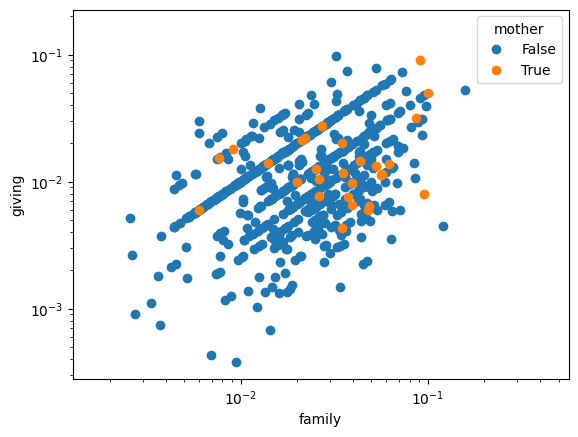

In [39]:
x_feat = 'family'
y_feat = 'giving'
label = 'mother'

fig, ax = plt.subplots()
for label_value in labels[label].unique():
    mask = labels[label]==label_value
    ax.loglog(feature_table.loc[mask, x_feat], feature_table.loc[mask, y_feat], marker='o', linestyle='', label=label_value)
ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.legend(title=label)
plt.show()

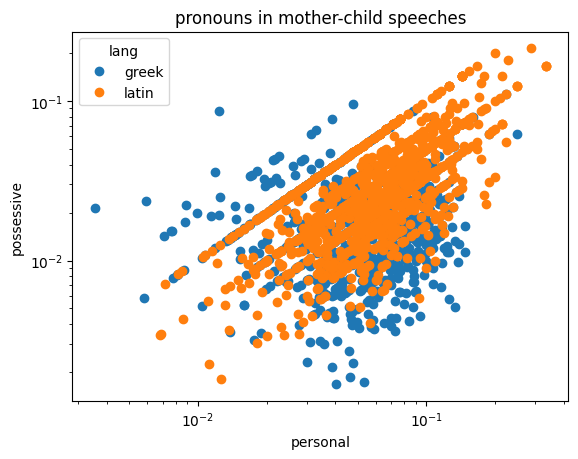

In [40]:
x_feat = 'personal'
y_feat = 'possessive'
label = 'lang'

fig, ax = plt.subplots()
for label_value in labels[label].unique():
    mask = labels[label]==label_value
    ax.loglog(feature_table.loc[mask, x_feat], feature_table.loc[mask, y_feat], marker='o', linestyle='', label=label_value)
ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.legend(title=label)
ax.set_title('pronouns in mother-child speeches')
plt.savefig('pron.png')
plt.show()

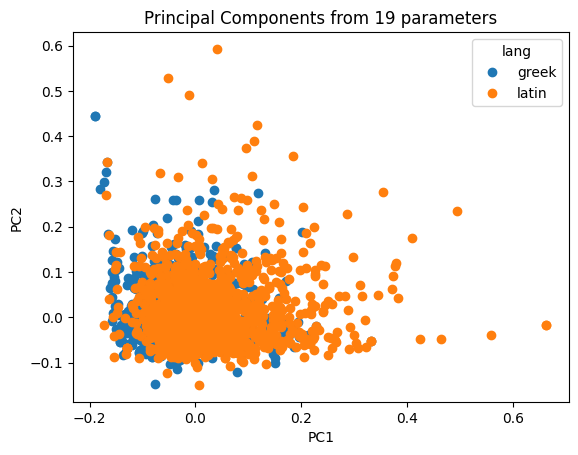

In [41]:
x_feat = 'PC1'
y_feat = 'PC2'
label = 'lang'

fig, ax = plt.subplots()
for label_value in labels[label].unique():
    mask = labels[label]==label_value
    ax.plot(pca.loc[mask, x_feat], pca.loc[mask, y_feat], marker='o', linestyle='', label=label_value)
ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.legend(title=label)
ax.set_title(f'Principal Components from {len(feature_table.columns)} parameters')
plt.savefig('foo.png')

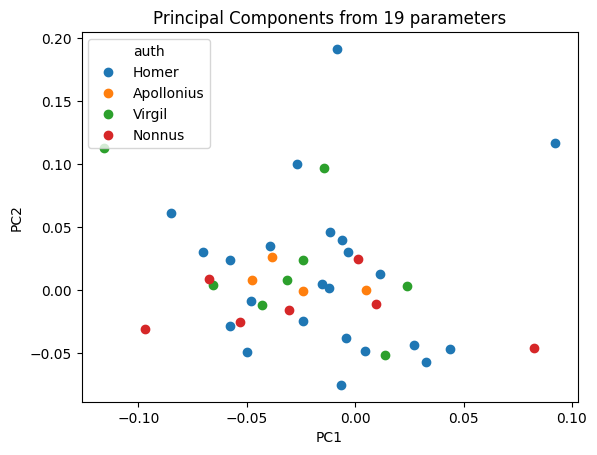

In [45]:
x_feat = 'PC1'
y_feat = 'PC2'
label = 'auth'

fig, ax = plt.subplots()
for label_value in ['Homer', 'Apollonius', 'Virgil', 'Nonnus']:
    mask = (labels[label]==label_value) & labels.mother
    ax.plot(pca.loc[mask, x_feat], pca.loc[mask, y_feat], marker='o', ls='', label=label_value)
ax.set_xlabel(x_feat)
ax.set_ylabel(y_feat)
ax.legend(title=label)
ax.set_title(f'Principal Components from {len(feature_table.columns)} parameters')
plt.savefig('foo.png')